In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from scipy import signal
import neurokit2 as nk
import pywt

In [99]:
## import data
data = pd.read_csv('heel/heel_50ppm.csv')

## clean
data = data.drop(columns=['Activity', 'User', 'Trial Number'])
data = data.drop([0])
data['Arduino Time'] = data['Arduino Time'] - data.loc[1]['Arduino Time']

data

,Time,Arduino Time,accel_X,accel_Y,accel_Z,gyro_X,gyro_Y,gyro_Z
1,52640.958,0.000000,-9.456435,2.222932,0.988236,-0.085521,0.002443,0.107512
2,52640.959,0.002014,-9.456435,2.222932,0.988236,-0.085521,0.002443,0.107512
3,52640.959,0.005005,-9.456435,2.222932,0.988236,-0.085521,0.002443,0.107512
4,52640.973,0.007019,-9.456435,2.222932,0.988236,-0.085521,0.002443,0.107512
5,52640.974,0.020020,-9.456435,2.222932,0.988236,-0.085521,0.002443,0.107512
...,...,...,...,...,...,...,...,...
1569,52729.233,88.277008,-9.785448,0.976272,-0.708275,0.089186,-0.052534,0.008552
1570,52729.263,88.291016,-9.756735,0.976272,-0.480957,0.036652,-0.095295,0.008552
1571,52729.308,88.351013,-9.714860,0.917647,-0.386441,0.007330,-0.052534,-0.069639
1572,52729.338,88.383026,-9.714860,0.859023,-0.393619,0.020769,-0.052534,-0.095295


In [100]:
## data arrays
time = data['Arduino Time']
accel_X = data['accel_X']
accel_Y = data['accel_Y']
accel_Z = data['accel_Z']
gyro_X = data['gyro_X']
gyro_Y = data['gyro_Y']
gyro_Z = data['gyro_Z']

### Accel X

In [101]:
## resampling
## find unique values
df_aX = pd.DataFrame({'time': time, 'accel_X': accel_X})
df_aX = df_aX.drop_duplicates(subset='accel_X')
df_aX = df_aX.reset_index(drop = True)
df_aX


,time,accel_X
0,0.000000,-9.456435
1,0.245026,-9.852448
2,0.285004,-9.659825
3,0.345001,-9.724432
4,0.395020,-9.600005
...,...,...
976,88.190002,-9.663414
977,88.246002,-9.785448
978,88.291016,-9.756735
979,88.351013,-9.714860


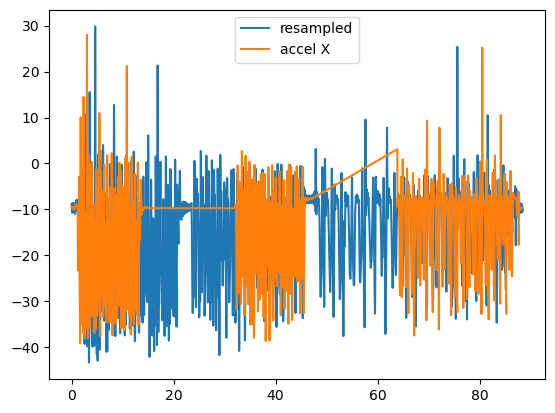

In [102]:
## interpolate to make frequency 100 HZ
num_samp = int(df_aX['time'].iloc[-1]*100)
rs_acc_X = signal.resample(df_aX['accel_X'], num_samp)
rs_time = np.linspace(0, df_aX['time'].iloc[-1], num_samp)

plt.plot(rs_time, rs_acc_X, label='resampled')
plt.plot(df_aX['time'], df_aX['accel_X'], label = 'accel X')
plt.legend()

### Processing of data without resampling

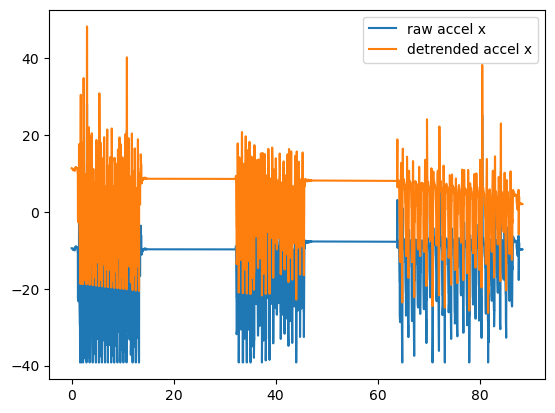

In [106]:
## accel_X signal processing
aX_detrend = signal.detrend(accel_X)

plt.plot(time, accel_X, label='raw accel x')
plt.plot(time,aX_detrend, label='detrended accel x')
plt.legend()

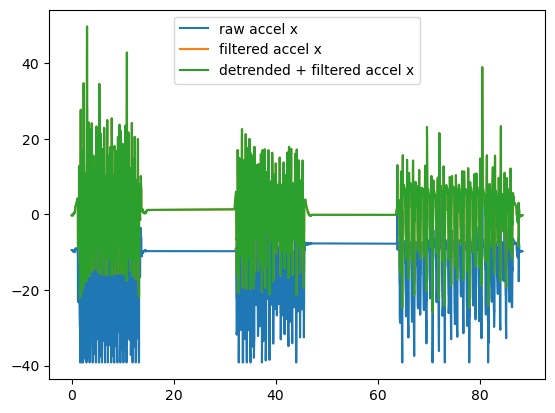

In [107]:
## butterworth
aX_filt = nk.signal_filter(accel_X, sampling_rate = 500, lowcut = 6, method = "butterworth", order = 2)
aX_d_filt = nk.signal_filter(aX_detrend, sampling_rate = 500, lowcut = 6, method = "butterworth", order = 2)

plt.plot(time, accel_X, label='raw accel x')
plt.plot(time,aX_filt, label='filtered accel x')
plt.plot(time,aX_d_filt, label='detrended + filtered accel x')
plt.legend()

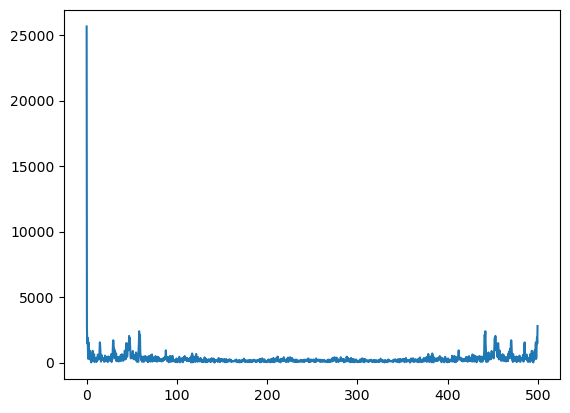

In [108]:
## FFT
sampling = 500
FFT =np.fft.fft(accel_X)
N=int(len(FFT)) 
n = np.arange(N)
T = N/sampling
freq = n/T

plt.plot(freq, np.abs(FFT))


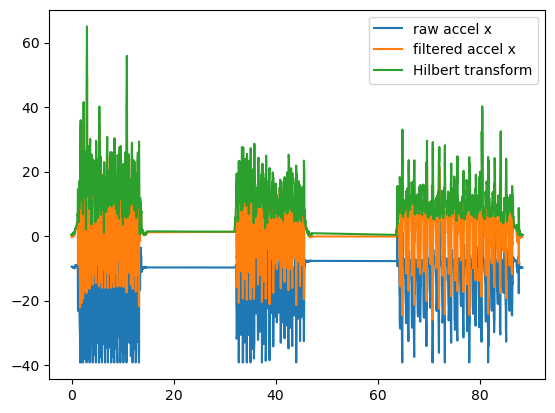

In [26]:
## extract envelope of filtered data
aX_hilbert = np.abs(signal.hilbert(aX_d_filt))

plt.plot(time, accel_X, label='raw accel x')
plt.plot(time,aX_filt, label='filtered accel x')
plt.plot(time,aX_hilbert, label='Hilbert transform')
plt.legend()

(2.0, 4.0)

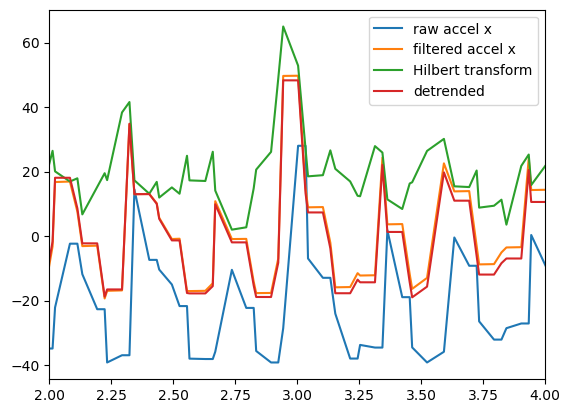

In [28]:
## shortened data
cut = data[data['Arduino Time']<20].index.values

aX_short = accel_X[cut]
aX_d_short = aX_detrend[cut]
aX_filt_short = aX_filt[cut]
aX_hilbert_short = aX_hilbert[cut]

plt.plot(time[cut], aX_short, label='raw accel x')
plt.plot(time[cut],aX_filt_short, label='filtered accel x')
plt.plot(time[cut],aX_hilbert_short, label='Hilbert transform')
plt.plot(time[cut],aX_d_short, label='detrended')
plt.legend()
plt.xlim(2,4)

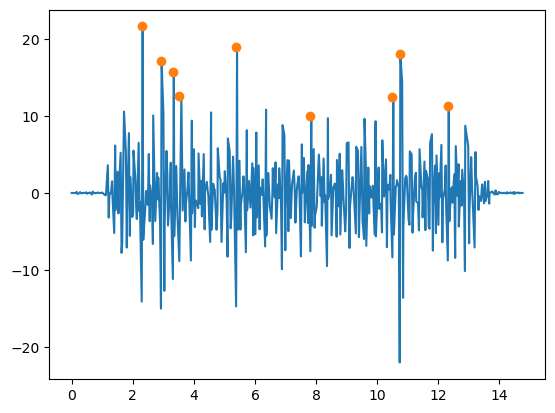

In [13]:
## peaks

aX_peaks = nk.signal_findpeaks(aX_filt_short, height_min=19.5)
pk_idx = aX_peaks['Peaks']

plt.plot(time[cut],aX_filt_short)
plt.plot(time[pk_idx],aX_filt_short[pk_idx],'o')

In [11]:
time[pk_idx]

58      1.654022
75      2.294006
93      2.924011
104     3.314026
110     3.524017
137     4.534027
161     5.384003
188     6.334015
231     7.814026
245     8.359009
307    10.499023
314    10.739014
359    12.314026
Name: Arduino Time, dtype: float64

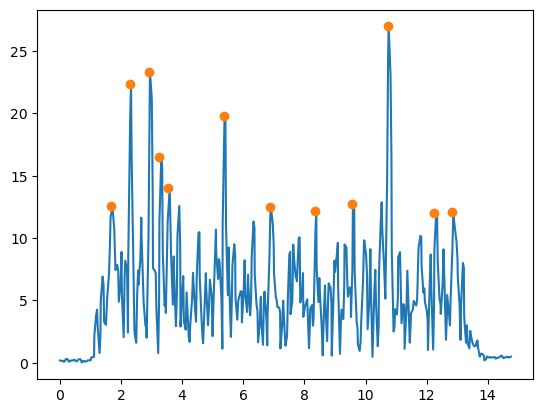

In [15]:
hilb_pks = nk.signal_findpeaks(aX_hilbert_short, height_min=10)
h_pk_idx = hilb_pks['Peaks']
plt.plot(time[cut],aX_hilbert_short)
plt.plot(time[h_pk_idx],aX_hilbert_short[h_pk_idx],'o')

In [16]:
time[h_pk_idx]

58      1.654022
75      2.294006
93      2.924011
103     3.254028
110     3.524017
161     5.384003
204     6.884003
245     8.359009
281     9.571014
314    10.739014
358    12.254028
374    12.844025
Name: Arduino Time, dtype: float64

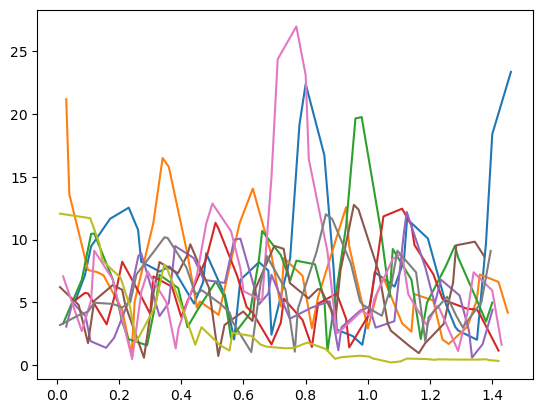

In [97]:
## raster plot

window = 1.2
step = .002

start = next(x for x, val in enumerate(time) if val > 1.6)

resamp = []

for i in range(0, int(len(aX_hilbert)/40-30)):
    plt.plot(time[(start+40*i):(start+40*(i+1))]-time[start+40*i], aX_hilbert[(start+40*i):(start+40*(i+1))])


### Processing with resampling

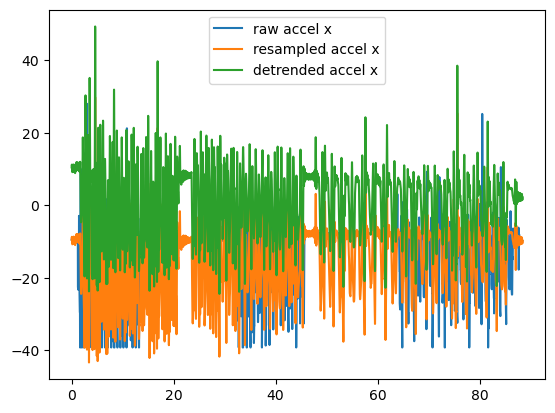

In [109]:
rs_aX_detrend = signal.detrend(rs_acc_X)

plt.plot(time, accel_X, label = 'raw accel x')
plt.plot(rs_time, rs_acc_X, label='resampled accel x')
plt.plot(rs_time, rs_aX_detrend, label='detrended accel x')
plt.legend()

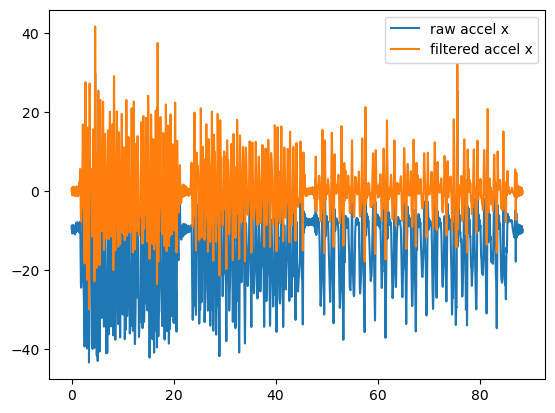

In [97]:
## butterworth
rs_aX_filt = nk.signal_filter(rs_acc_X, lowcut = 10, method = "butterworth", order = 2)
# rs_aX_d_filt3 = nk.signal_filter(rs_aX_detrend, sampling_rate = 100, highcut = 100, method = "butterworth", order = 2)
# rs_aX_d_filt10 = nk.signal_filter(rs_aX_detrend, sampling_rate = 100, highcut = 100, method = "butterworth", order = 2)


## envelope
rs_aX_hilbert = np.abs(signal.hilbert(rs_aX_filt))

plt.plot(rs_time, rs_acc_X, label='raw accel x')
plt.plot(rs_time, rs_aX_filt, label='filtered accel x')
# plt.plot(rs_time, rs_aX_d_filt3, label='3 Hz filter')
# plt.plot(rs_time, rs_aX_d_filt10, label='10 Hz filter')
# plt.plot(rs_time, rs_aX_hilbert, label='envelope')
plt.legend()

(2.0, 10.0)

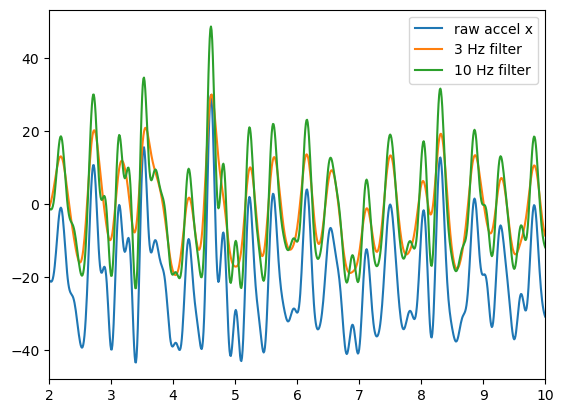

In [77]:
plt.plot(rs_time, rs_acc_X, label='raw accel x')
# plt.plot(rs_time, rs_aX_filt, label='filtered accel x')
plt.plot(rs_time, rs_aX_d_filt3, label='3 Hz filter')
plt.plot(rs_time, rs_aX_d_filt10, label='10 Hz filter')
# plt.plot(rs_time, rs_aX_hilbert, label='envelope')
plt.legend()
plt.xlim(2,10)

Text(0, 0.5, 'FFT Amplitude |X(freq)|')

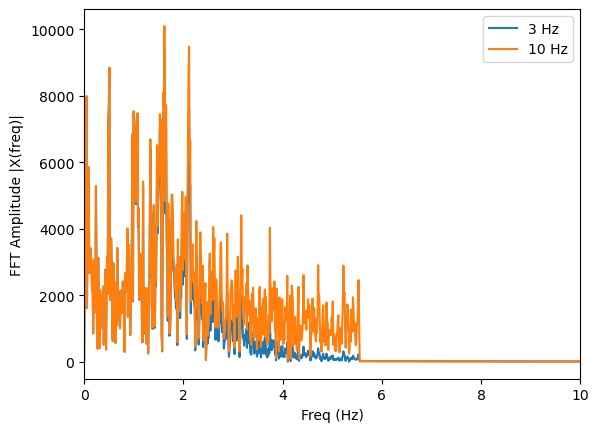

In [88]:
## FFT
sampling = 100
FFT = np.fft.fft(rs_acc_X)
FFT3 =np.fft.fft(rs_aX_d_filt3)
FFT10 =np.fft.fft(rs_aX_d_filt10)
N = len(FFT)
n = np.arange(N)
T = N/sampling
freq = n/T

# plt.plot(freq, np.abs(FFT), label='raw')
plt.plot(freq, np.abs(FFT3), label='3 Hz')
plt.plot(freq, np.abs(FFT10), label='10 Hz')
plt.legend()
plt.xlim(0,10)
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')

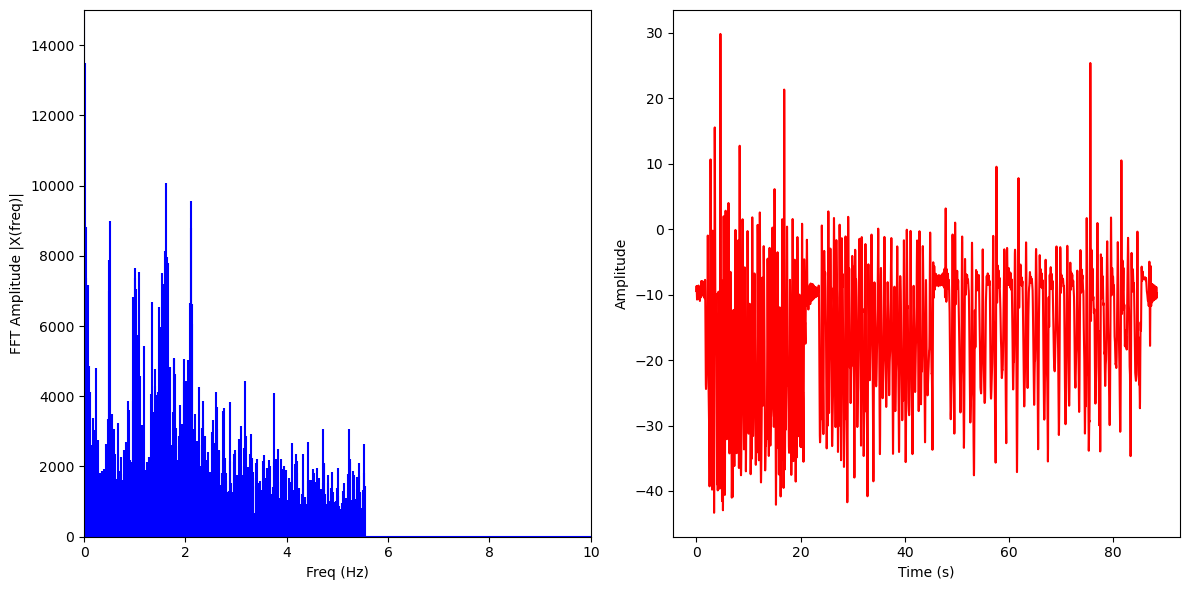

In [92]:
plt.figure(figsize = (12, 6))
plt.subplot(121)

plt.stem(freq, np.abs(FFT), 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.xlim(0, 10)
plt.ylim(0,15000)

plt.subplot(122)
plt.plot(rs_time, np.fft.ifft(FFT), 'r')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

/Users/isabellagomez/anaconda3/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


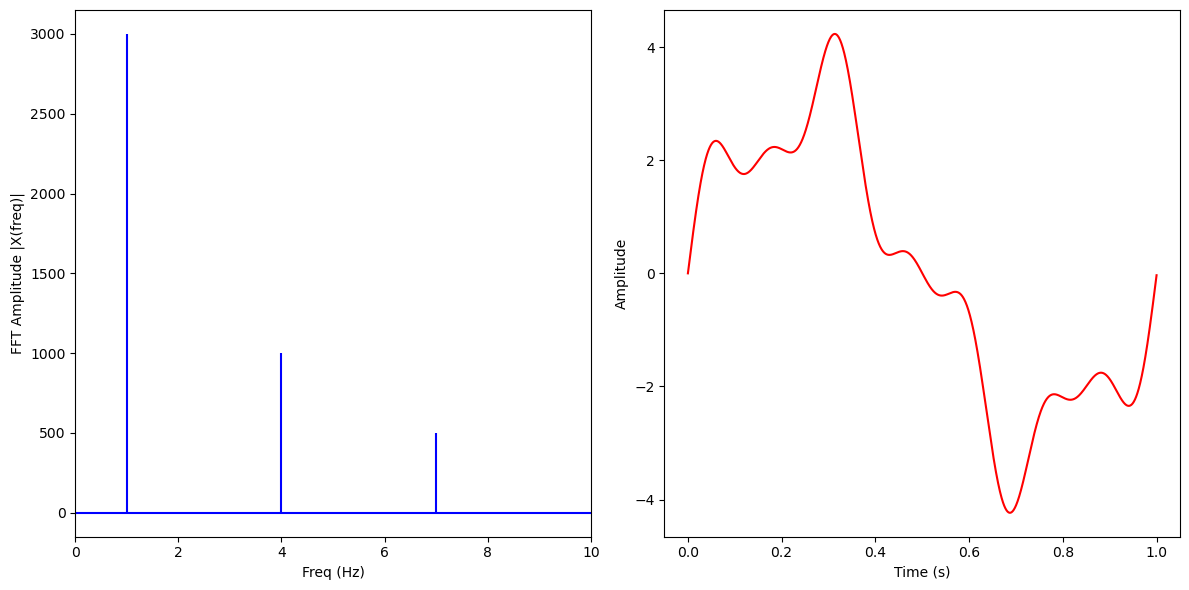

In [81]:
# sampling rate
sr = 2000
# sampling interval
ts = 1.0/sr
t = np.arange(0,1,ts)

freq = 1.
x = 3*np.sin(2*np.pi*freq*t)

freq = 4
x += np.sin(2*np.pi*freq*t)

freq = 7   
x += 0.5* np.sin(2*np.pi*freq*t)

X = np.fft.fft(x)
N = len(X)
n = np.arange(N)
T = N/sr
freq = n/T 

plt.figure(figsize = (12, 6))
plt.subplot(121)

plt.stem(freq, np.abs(X), 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.xlim(0, 10)

plt.subplot(122)
plt.plot(t, np.fft.ifft(X), 'r')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

KeyError: 1575

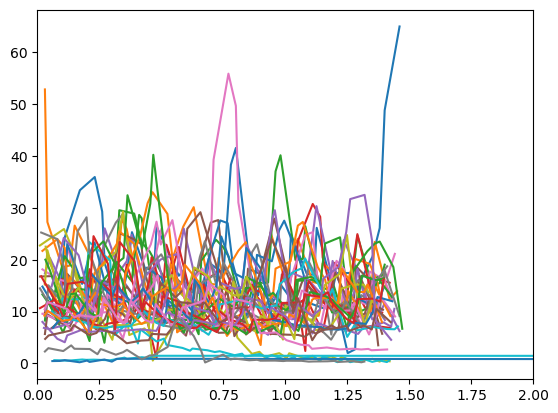

In [113]:
## raster plot

window = 1.2
step = .002

start = next(x for x, val in enumerate(time) if val > 1.6)

resamp = []

for i in range(0, int(len(rs_acc_X)/40-30)):
    plt.plot(time[(start+40*i):(start+40*(i+1))]-time[start+40*i], aX_hilbert[(start+40*i):(start+40*(i+1))])
    plt.xlim(0,2)



### Accel Y

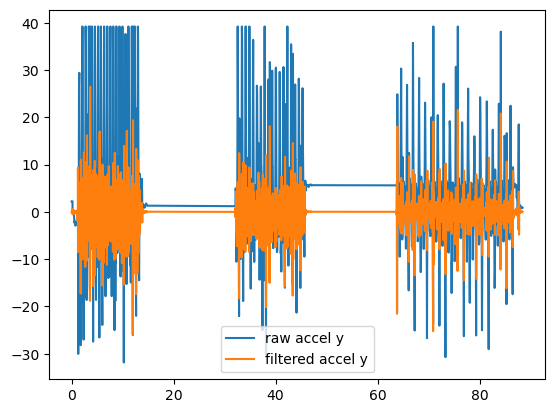

In [22]:
## accel_Y signal processing
## butterworth
aY_filt = nk.signal_filter(accel_Y, sampling_rate = 30, lowcut = 6, method = "butterworth", order = 2)

plt.plot(time, accel_Y, label='raw accel y')
plt.plot(time,aY_filt, label='filtered accel y')
plt.legend()

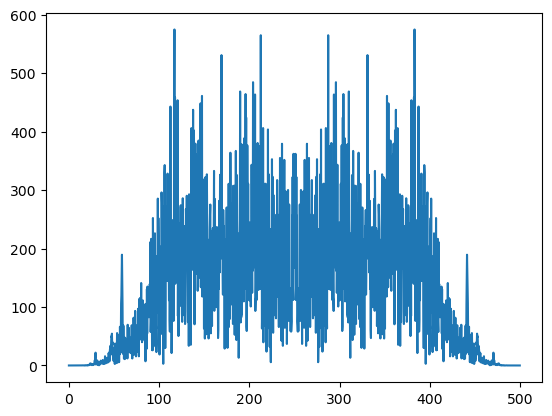

In [23]:
## FFT

sampling = 500
FFT =np.fft.fft(aY_filt)
N=int(len(FFT)) 
n = np.arange(N)
T = N/sampling
freq = n/T

plt.plot(freq, np.abs(FFT))

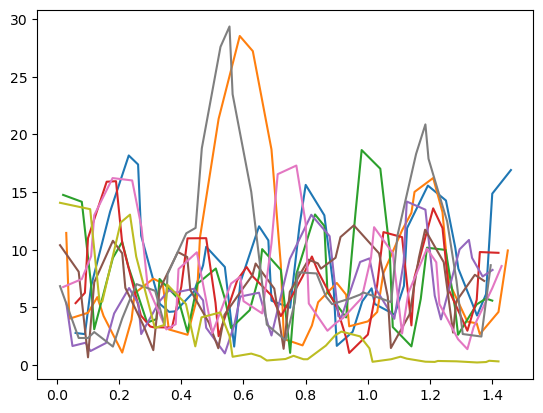

In [107]:
aY_hilbert = np.abs(signal.hilbert(aY_filt))

for i in range(0, int(len(aY_hilbert)/40-30)):
    plt.plot(time[(start+40*i):(start+40*(i+1))]-time[start+40*i], aY_hilbert[(start+40*i):(start+40*(i+1))])

### Accel Z

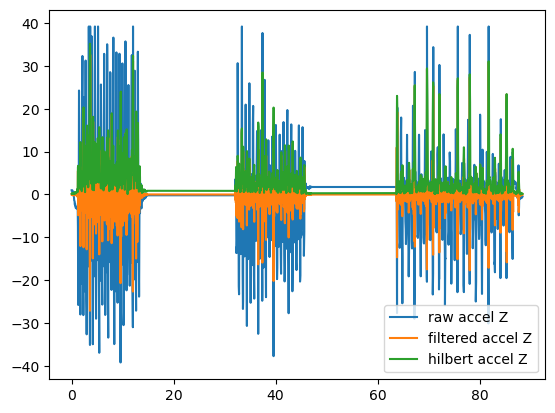

In [111]:
aZ_filt = nk.signal_filter(accel_Z, sampling_rate = 30, lowcut = 6, method = "butterworth", order = 2)
aZ_hilbert = np.abs(signal.hilbert(aZ_filt))

plt.plot(time, accel_Z, label='raw accel Z')
plt.plot(time,aZ_filt, label='filtered accel Z')
plt.plot(time, aZ_hilbert, label='hilbert accel Z')
plt.legend()

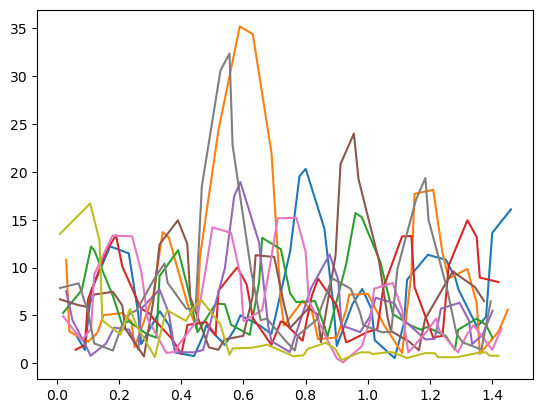

In [109]:
for i in range(0, int(len(aZ_hilbert)/40-30)):
    plt.plot(time[(start+40*i):(start+40*(i+1))]-time[start+40*i], aZ_hilbert[(start+40*i):(start+40*(i+1))])

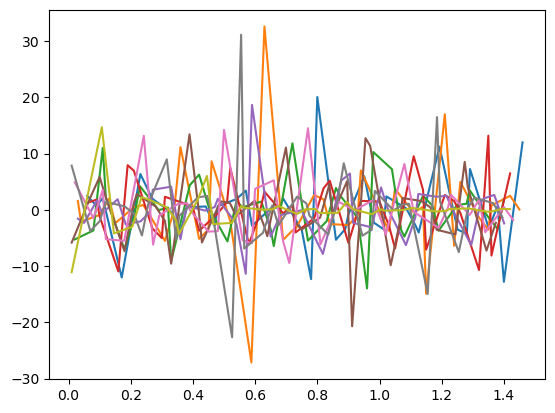

In [110]:
for i in range(0, int(len(aZ_filt)/40-30)):
    plt.plot(time[(start+40*i):(start+40*(i+1))]-time[start+40*i], aZ_filt[(start+40*i):(start+40*(i+1))])

### Gyro X

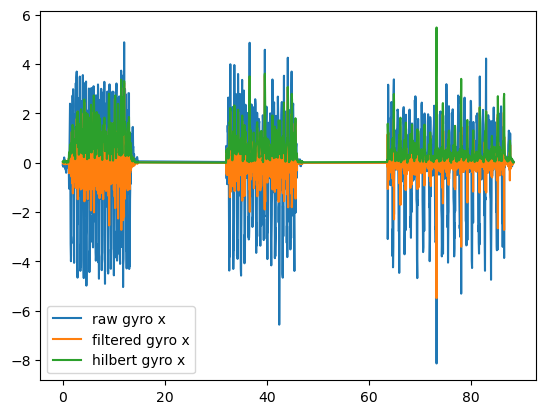

In [113]:
gX_filt = nk.signal_filter(gyro_X, sampling_rate = 30, lowcut = 6, method = "butterworth", order = 2)
gX_hilbert = np.abs(signal.hilbert(gX_filt))

plt.plot(time, gyro_X, label='raw gyro x')
plt.plot(time,gX_filt, label='filtered gyro x')
plt.plot(time, gX_hilbert, label='hilbert gyro x')
plt.legend()

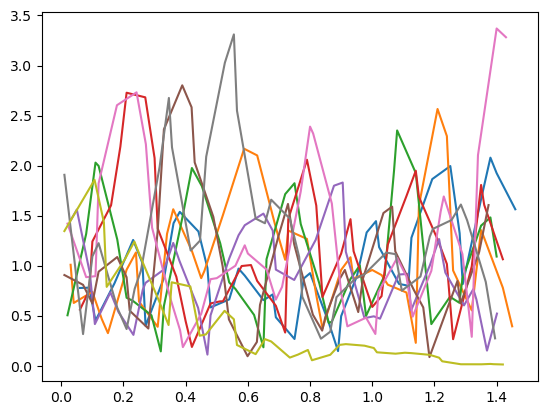

In [114]:
for i in range(0, int(len(gX_hilbert)/40-30)):
    plt.plot(time[(start+40*i):(start+40*(i+1))]-time[start+40*i], gX_hilbert[(start+40*i):(start+40*(i+1))])

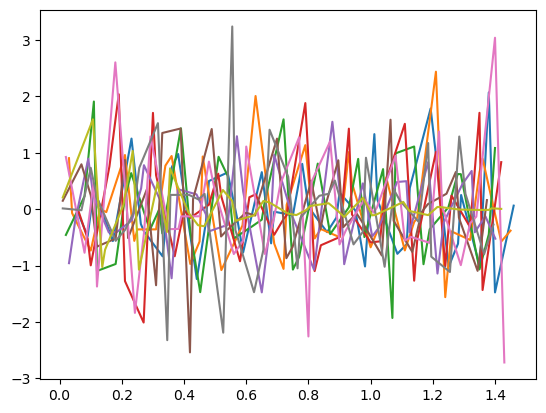

In [115]:
for i in range(0, int(len(gX_filt)/40-30)):
    plt.plot(time[(start+40*i):(start+40*(i+1))]-time[start+40*i], gX_filt[(start+40*i):(start+40*(i+1))])

# Event Segmentation

In [ ]:
accel_X = data['accel_X']
accel_Y = data['accel_Y']
accel_Z = data['accel_Z']
gyro_X = data['gyro_X']
gyro_Y = data['gyro_Y']
gyro_Z = data['gyro_Z']